In [1]:
import itertools
import os
import pickle as pkl

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import fetch_openml

%load_ext autoreload
%autoreload 2

# change working directory to project root
if os.getcwd().split('/')[-1] != 'imodels':
    os.chdir('..')

MODEL_COMPARISON_PATH = 'tests/test_data/comparison_data/'

In [2]:
datasets = [
        ("breast-cancer", 13),
        ("breast-w", 15),
        ("credit-g", 31),
        ("haberman", 43),
        ("heart", 1574),
        ("labor", 4),
        ("vote", 56),
    ]

def get_comparison_result(path, estimator_name, test=False):
    if test:
        result_file = path + f'{estimator_name}_test_comparisons.pkl'
    else:
        result_file = path + f'{estimator_name}_comparisons.pkl'
    return pkl.load(open(result_file, 'rb'))

def get_all_results(path, test=False):
    if test:
        fn = lambda x: '_test_' in x
    else:
        fn = lambda x: '_test_' not in x
    result_files = list(filter(fn, os.listdir(path)))
    all_results_df = pd.Series([], dtype='float32')
    all_est_names = []
    for result_file in result_files:
        result = pkl.load(open(MODEL_COMPARISON_PATH + result_file, 'rb'))
        all_results_df = pd.concat([all_results_df, result['df']])
        all_est_names += result['estimators']
    return {'df': all_results_df, 'estimators': all_est_names}

def viz_comparison(result, dpi=83):
    '''Plot ROC AUC vs complexity
    '''
    result_df, result_estimators = result['df'], result['estimators']
    plt.figure(dpi=dpi)
    for est in np.unique(result_estimators):
        
        est_result_df = result_df[result_df.index.str.contains(est)]
        complexities = est_result_df[est_result_df.index.str.contains('Complexity')]
        rocs = est_result_df[est_result_df.index.str.contains('ROC')]
        complexity_sort_indices = complexities.argsort()

        plt.plot(complexities[complexity_sort_indices], rocs[complexity_sort_indices], label=est.replace('_', ' '))
    
    plt.xlabel('Complexity score')
    plt.ylabel('Average ROC AUC across comparison datasets')
    plt.legend(frameon=False, handlelength=1)
    plt.show()

# dataset stats

In [3]:
metadata = []
columns = ['name', 'samples', 'features', 'class 0 ct', 'class 1 ct', 'majority class %']
for dataset_name, data_id in datasets:
    dataset = fetch_openml(data_id=data_id, as_frame=False)
    shape = dataset.data.shape
    class_counts = np.unique(dataset.target, return_counts=True)[1]
    metadata.append([dataset_name, shape[0], shape[1], class_counts[0], class_counts[1], np.max(class_counts) / np.sum(class_counts)])
pd.DataFrame(metadata, columns=columns).set_index('name')

,samples,features,class 0 ct,class 1 ct,majority class %
name,,,,,
breast-cancer,286,9,201,85,0.702797
breast-w,699,9,458,241,0.655222
credit-g,1000,20,300,700,0.700000
haberman,306,3,225,81,0.735294
heart,270,13,150,120,0.555556
labor,57,16,20,37,0.649123
vote,435,16,267,168,0.613793


# complexity vs. ROC Area plot for all models

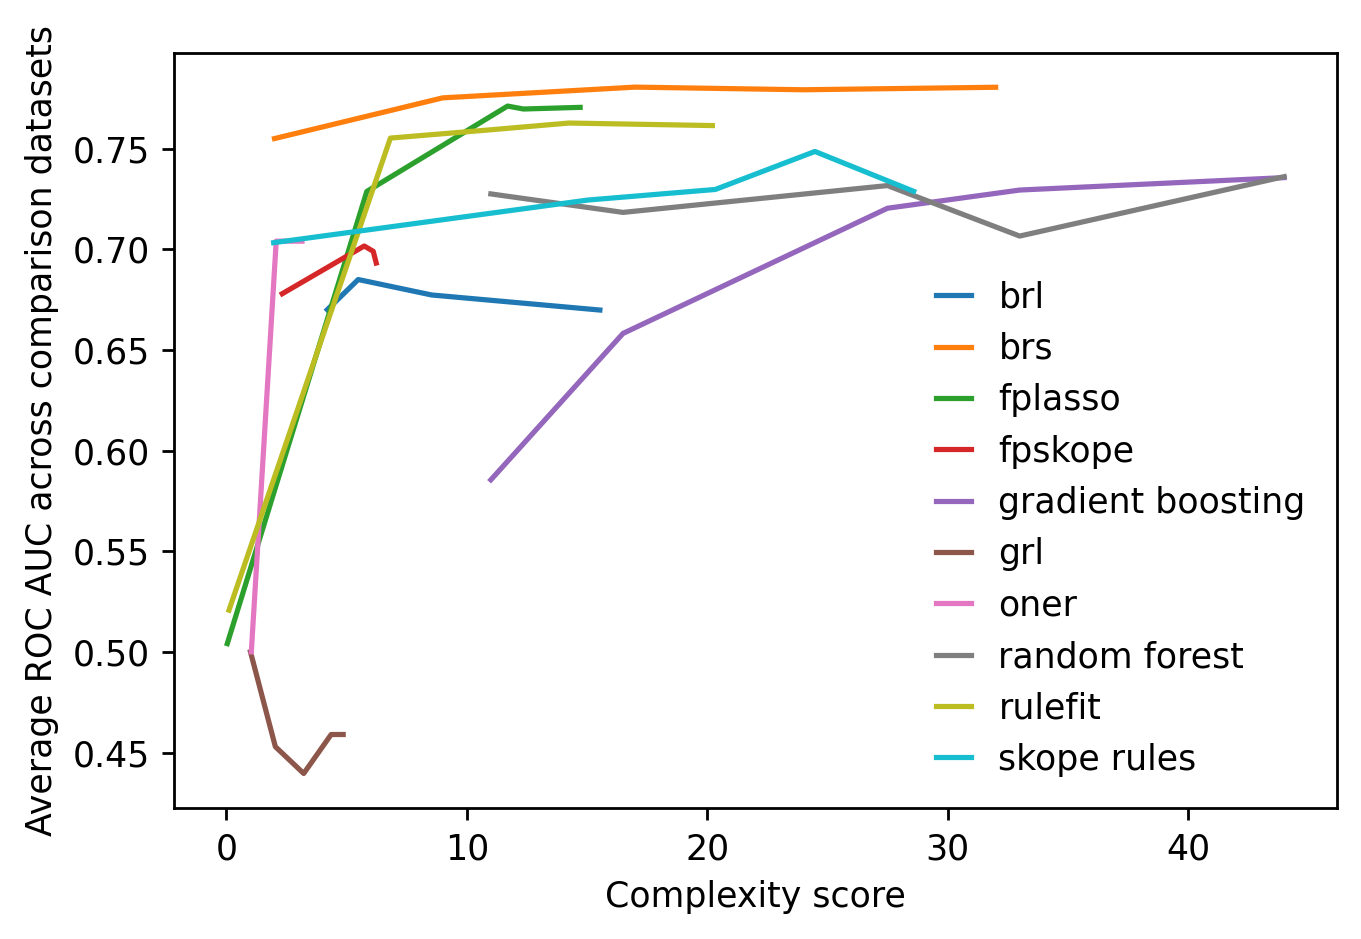

In [4]:
result_files = get_all_results(MODEL_COMPARISON_PATH, test=True)
viz_comparison(result_files, 250)

# hyperparameter tuning plots for each model


## Random Forest

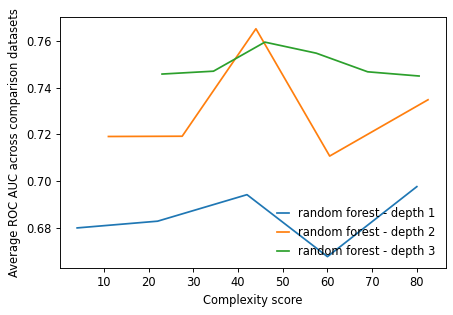

In [5]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'random_forest')
viz_comparison(comparison_result)

## Gradient boosted trees

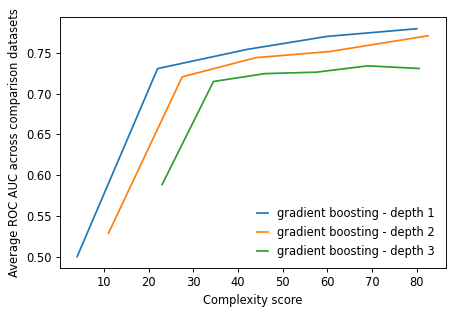

In [6]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'gradient_boosting')
viz_comparison(comparison_result)

## SkopeRules

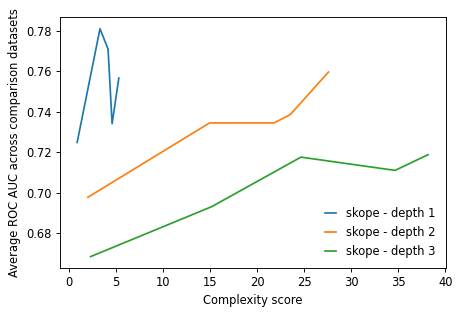

In [7]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'skope_rules')
viz_comparison(comparison_result)

## RuleFit

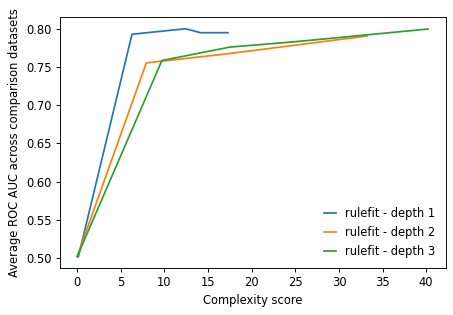

In [8]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'rulefit')
viz_comparison(comparison_result)

## FPLasso

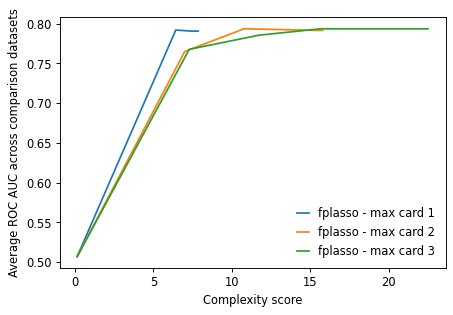

In [9]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'fplasso')
viz_comparison(comparison_result)

## FPSkope

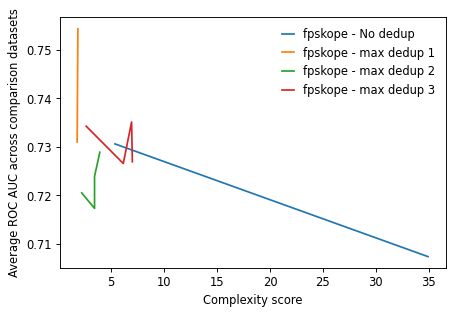

In [10]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'fpskope')
viz_comparison(comparison_result)

## BRL

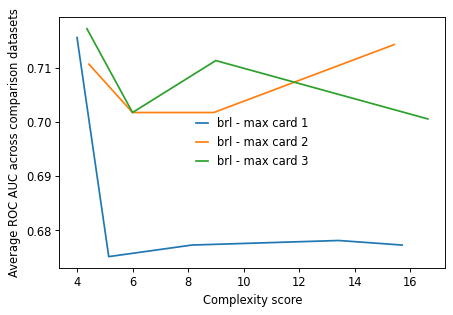

In [11]:
comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, 'brl')
viz_comparison(comparison_result)